## Five Main Steps for selecting a classifier:
   - Selecting features and collecting labeled training examples
   - Choosing performance metric
   - Choosing a learning algorithm and training a model
   - Evaluating  the performance of the model
   - Changing the settings of the algorithm and tuning the model

# Perceptron Classifier Algorithm

In [1]:
#implementing perceptron rule and Adaline with Scikit learn
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:, [2,3]]
y = iris.target
print('Class labels:', np.unique(y))


Class labels: [0 1 2]


## To evaluate hgow well a trained model performs on unseen data, we split data set into separate training and test datasets.

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state= 1, stratify = y #stratify makes all y values occur at the same proportions
)

In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() #StandardScaler is used for feature scaling.
sc.fit(X_train) # calculates the mean and standard deviation
X_train_std = sc.transform(X_train) #standardizes the data with the mean and standard deviation
X_test_std = sc.transform(X_test) #standardizes the data with the mean and standard deviation

In [4]:
#checking our training model and caluclating it's accuracy
from sklearn.linear_model import Perceptron
ppn = Perceptron(eta0=0.01, random_state=1)
ppn.fit(X_train_std, y_train)

#checking the misclassifcation
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' %(y_test != y_pred).sum())

#checking the model accuracy
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

#alternative: checking model accuracy using inbuilt perceptron accuracy method
print('Accuracy: %.3f' %ppn.score(X_test_std, y_test))

Misclassified examples: 2
Accuracy: 0.956
Accuracy: 0.956


## Plotting decision regions

In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X,y,classifier,test_idx = None, resolution = 0.02):
    #setup marker generator and color map
    markers = ('o','s','^', 'v','<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #plot the decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1,xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    #plot class examples
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter( x = X[y == c1,0],
                     y = X[y == c1,1],
                     alpha = 0.8,
                     c = colors[idx],
                     marker = markers[idx],
                     label = f'Class {c1}',
                     edgecolor = 'black'
                   )
    #hihglight test examples
    if test_idx:
        #plot all examples
        X_test, y_test = X[test_idx, :] , y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:,1],
                   c='none', edgecolor='black', alpha=1.0,
                   s=100, label='Test set')
    

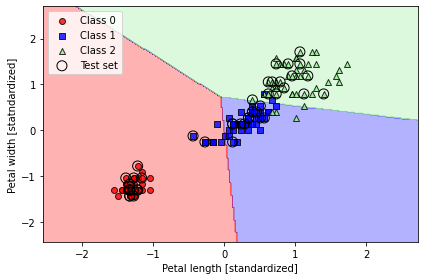

In [6]:
#we can now specify the indices of the examples we want to map on the plot.
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined, classifier = ppn, test_idx = range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [statndardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Inference: Perceptron Classfiers never converges  on datasets that are not perfectly linearly separable.
## Which is why perceptron algorithm is typically not recommended in practice.

# Implementing Logistic Regression

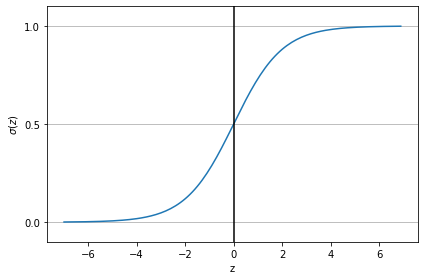

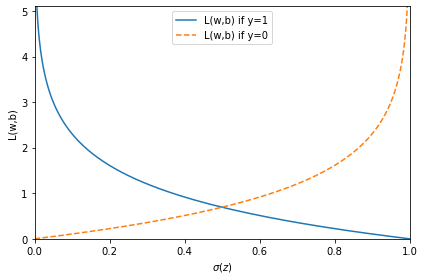

In [7]:
## sigmoid function for some values range -7 to 7 

import matplotlib.pyplot as plt
import numpy as np
def sigmoid(z):
    return 1.0/ (1.0 + np.exp(-z))
z = np.arange(-7,7,0.1)
sigma_z = sigmoid(z)
plt.plot(z,sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')
#y axis ticks and grindline
plt.yticks([0.0,0.5,1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

#plot of loss of classifying a single training example for different standard deviation values of z
def loss_1(z):
    return -np.log(sigmoid(z))

def loss_0(z):
    return -np.log(1 - sigmoid(z))

z = np.arange(-10,10,0.1)
sigma_z = sigmoid(z)
c1 =[loss_1(x) for x in z]
plt.plot(sigma_z,c1, label='L(w,b) if y=1')
c0 = [loss_0(x) for x in z]
plt.plot(sigma_z, c0, linestyle='--', label= 'L(w,b) if y=0')
plt.ylim(0.0,5.1)
plt.xlim([0,1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w,b)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



## Classifying the setosa and versicolor 0 and 1 to see the working of  logistic regression. 

In [8]:
class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier.
    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.
    Attributes
    -----------
    w_ : 1d-array
      Weights after training.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        Returns
        -------
        self : Instance of LogisticRegressionGD
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * errors.mean()
            loss = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))) / X.shape[0]
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)


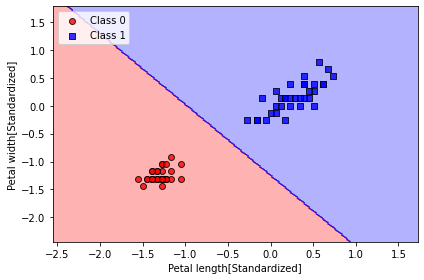

In [9]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lgrd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lgrd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X=X_train_01_subset, y = y_train_01_subset, classifier=lgrd)
plt.xlabel('Petal length[Standardized]')
plt.ylabel('Petal width[Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

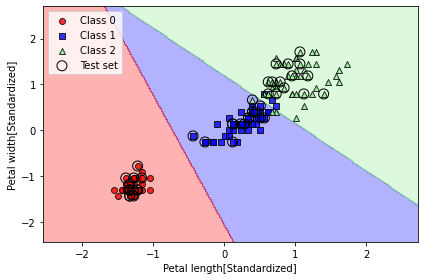

"\nFor minimizing the convex loss functions such as the logistic regression loss, it is recommended to use more advanced \napproaches than regular Stochastic gradient descent(SGD)\nScikit Learn has range of optimizing algorithms such as: 'newton-cg', 'lbfgs', 'liblinear', 'sag' and 'saga'\n"

In [10]:
## Training a logistic regression model with scikit-learn
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=lr,test_idx=range(105,150))
plt.xlabel('Petal length[Standardized]')
plt.ylabel('Petal width[Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
"""
For minimizing the convex loss functions such as the logistic regression loss, it is recommended to use more advanced 
approaches than regular Stochastic gradient descent(SGD)
Scikit Learn has range of optimizing algorithms such as: 'newton-cg', 'lbfgs', 'liblinear', 'sag' and 'saga'
"""

In [11]:
#checking th probability that training examples belong to a certain class
lr.predict_proba(X_test_std[:3, :])
"""
the first row has a value of 8.5 at column 3 which means that the first example belongs to class 3 with a 
predicitve probability of 85%.

"""

'\nthe first row has a value of 8.5 at column 3 which means that the first example belongs to class 3 with a \npredicitve probability of 85%.\n\n'

In [12]:
#confirm the sum of each row probabilities.
lr.predict_proba(X_test_std[:3,:]).sum(axis=1)

array([1., 1., 1.])

In [13]:
#finding the class at which each example belongs to using the max probability values
lr.predict_proba(X_test_std[:3,:]).argmax(axis = 1)

array([2, 0, 0])

this corresponds to class Iris-virginica, Iris-setosa and Iris-setosa

In [14]:
#achieving the same results as above using only scikit learn without argmax
lr.predict(X_test_std[:3,:])

array([2, 0, 0])

this corresponds to class Iris-virginica, Iris-setosa and Iris-setosa

In [15]:
#lastly if we want to predict the class label of a single flower, we need to convert it to a 2D array for it to work
#on scikit learn.
lr.predict(X_test_std[0,:].reshape(1,-1))

array([2])

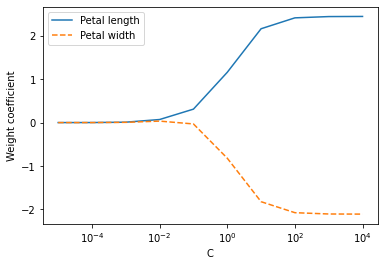

In [16]:
weights, params =[],[]
for c in np.arange(-5,5):
    lr= LogisticRegression(C=10.**c, multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:,0], label='Petal length')
plt.plot(params, weights[:,1], linestyle='--', label='Petal width')
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

increase in C reduces overfitting and vice-versa, however, if the C is too high, the model can perform poorly due to underfitting

# Support Vector Machines
## For Maximum Margin Classfifcations we use Support Vector Machines

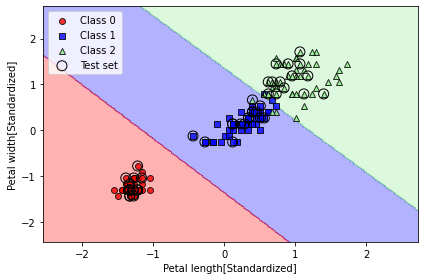

In [18]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,classifier=svm, test_idx= range(105,150))
plt.xlabel('Petal length[Standardized]')
plt.ylabel('Petal width[Standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# We could also use scikit learn a different way for large datasets that don't fit in computer memory as follows:

In [20]:
'''
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss='perceptron')#for perceptron model
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss = 'hinge')
'''


"\nfrom sklearn.linear_model import SGDClassifier\nppn = SGDClassifier(loss='perceptron')#for perceptron model\nlr = SGDClassifier(loss='log')\nsvm = SGDClassifier(loss = 'hinge')\n"

## Using Kernel method for linearly inseparable data

### using kernel method on dummy data.


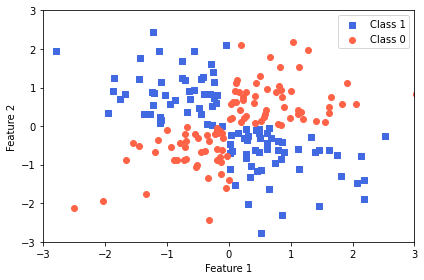

In [25]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0] > 0, X_xor[:,1] > 0)
y_xor = np.where(y_xor, 1, 0)
plt.scatter(X_xor[y_xor == 1, 0],
           X_xor[y_xor == 1, 1],
           c='royalblue', marker='s',
           label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0],
           X_xor[y_xor == 0, 1],
           c='tomato', marker='o',
           label='Class 0')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

### applying the kernel method using the radial basis function.

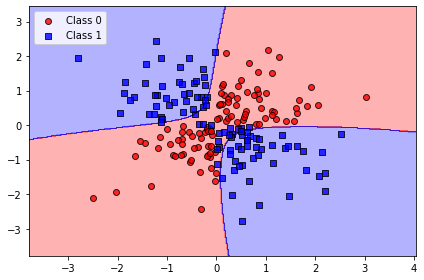

In [26]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### applying the kernel method on the Iris flower dataset

### understaning the gamma parameter. 


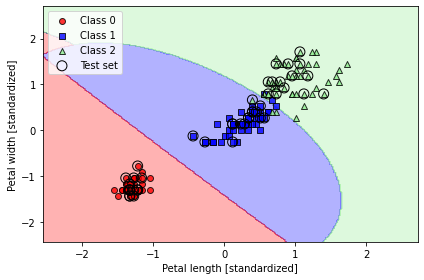

In [30]:
#using a small value for gamma.
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=10.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,
                     test_idx = range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

inference: since we chose a a small value for gamma, the decision boundary of the RBF Kernel SVM model will be
    relatively soft.

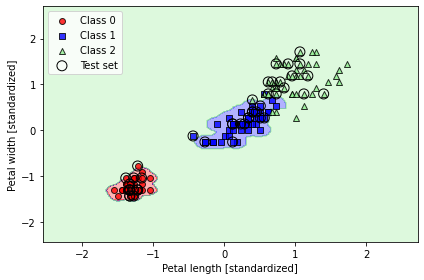

In [31]:
#using a larger value for gamma
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=10.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,
                     test_idx = range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### inference: Although the model fits the training dataset very well, such a classifier wwill likely have a high generalizationerror on unseen data. This illustrates that the gamma parameter also plays an important role in controlling overfitting or variance when the algorithm is too sensitive to fluctuations in the training data.

# Decision Trees

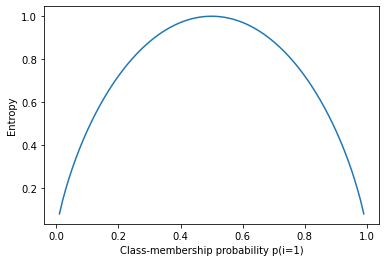

In [32]:
#Entropy is the measure of surprise in a data
#Visualizing entropy values for different class distribution
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1-p))
x = np.arange(0.0,1.0,0.01)
ent = [entropy(p) if p != 0 else None for p in x]
plt.ylabel('Entropy')
plt.xlabel('Class-membership probability p(i=1)')
plt.plot(x, ent)
plt.show()

## visual comparison of the three different impurity criteria

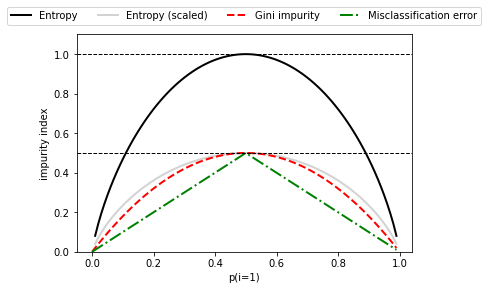

In [34]:
import matplotlib.pyplot as plt
import numpy as np
def gini(p):
    return p*(1-p) + (1 - p)*(1 - (1-p))

def entropy(p):
    return -p * np.log2(p) - (1 - p) * np.log2((1 - p))

def error(p):
    return 1 - np.max([p, 1-p])

x = np.arange(0.0,1.0,0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)

for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                        ['Entropy','Entropy (scaled)',
                        'Gini impurity', 'Misclassification error'],
                        ['-','-','--','-.'],
                        ['black','lightgray','red','green', 'cyan']):
    line = ax.plot(x, i, label=lab,
                  linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
plt.show()

### note: although feature scaling maybe desired for visualization purposes, note that feature scaling is not a requirement for decision tree algorithms

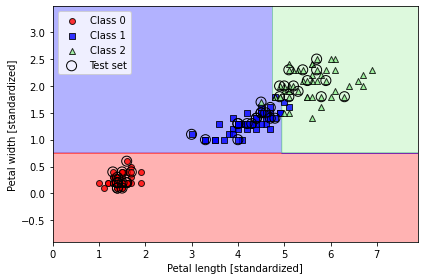

In [36]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(criterion='gini',max_depth=4, random_state=1)

tree_model.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, y_combined, classifier=tree_model, test_idx=range(105,150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

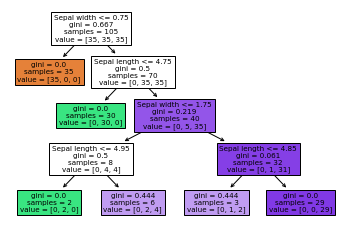

In [38]:
from sklearn import tree
feature_names = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width']
tree.plot_tree(tree_model, feature_names=feature_names, filled=True)
plt.show()

## Decision Trees with Random Forests

In [40]:
"""
The larger the number of trees the better the performance.
"""

'\nThe larger the number of trees the better the performance.\n'

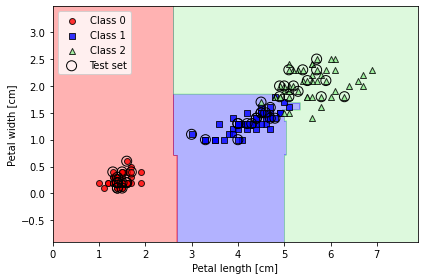

In [41]:
"""
For a number of features d, at each split, we ant to choose a value that is smaller than the total number of features 
in the training dataset. d =square root of (m) where m i sht number of features in the training dataset.
"""
#implementing Random Forest Classifier.
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 25, random_state=1, n_jobs=2)
forest.fit(X_train,y_train)
plot_decision_regions(X_combined,y_combined,
                      classifier=forest, test_idx=range(105,150))
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### inference we just trained random forest on 25 decision trees via the n_estimators

 # KNearest Neighbour Algorithm

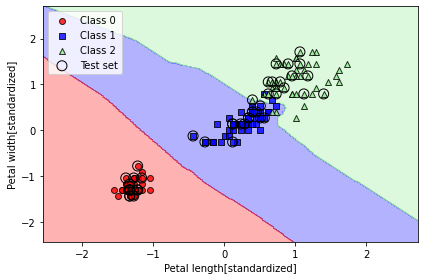

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined,
                     classifier=knn, test_idx=range(105,150))

plt.xlabel('Petal length[standardized]')
plt.ylabel('Petal width[standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

"""
* since metric used was minkowski, if p=2 then it's euclidean distance else p=1 will manhattan distance.
* KNN is also susceptible to the curse of dimensionality. The curse of dimensionality describes the situation were 
the feature space becomes increasingly wide with even the nearest neighbour being so far away in some sort of
high-dimensional space.

* The concept of Regularization can be used to prevent overfitting in logistic regression. However, in KNN and decisions
and models where Regularization can't be applied, we can use feature selection and deimensionality techniques to help 
us avoid the curse of dimensionality. 

"""